# Segmentation methodology for Chameleon

In [8]:
import importlib
from time import time
import numpy as np
from matplotlib import pyplot as plt
from tsfresh.feature_extraction.settings import (
    EfficientFCParameters,
)

from unsupervised_learning.unsupervised_sliding_windows_classification import classifyTrace_unsupervised, saveClassification
from inference_pipeline.segmentation import *
from inference_pipeline.debug import *

import inference_pipeline.heuristic as heuristic
importlib.reload(heuristic)
import unsupervised_learning.vectorization as vectorization
importlib.reload(vectorization)
import unsupervised_learning.classification as classification
importlib.reload(classification)

fc_params = EfficientFCParameters()
# Removing the least efficient features
fc_params.pop('query_similarity_count', None) # Often not applicable
fc_params.pop('augmented_dickey_fuller', None)
fc_params.pop('number_cwt_peaks', None)
fc_params.pop('agg_linear_trend', None)
fc_params.pop('change_quantiles', None)
fc_params.pop('lempel_ziv_complexity', None)
fc_params.pop('permutation_entropy', None)


window_size = 10_000
stride = 50 #50


#vectorizer = vectorization.TSFreshVectorizer(fc_params=fc_params, n_jobs=min(int(multiprocessing.cpu_count()/1.2), 64))
vectorizer = vectorization.AutoencoderVectorizer(window_size=window_size, base_lr=2e-4, lr_decay= 0.7)
#classifier = classification.KMeansClassifier(n_clusters=2)
classifier = classification.RadialThresholdClassifier()

In [2]:
dataset = 'BASE'
chunk = 1

chameleon_file = f"datasets/{dataset}/chameleon_{dataset.lower()}_chunk_{chunk}.h5"
output_file = "temporary_files/classification_file.npy"

batch_size = vectorizer.batch_data_points//window_size

Compute and save segmentation as file `output_file`.
Function _classifyTrace_ has a few parameters to configure based on the experiment:

- `stride`: Define the stride to use for the sliding window.
- `window_size`: Define the size of the sliding window itself.

Building all_X memmap: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Feature dimension after pipeline: 2/32


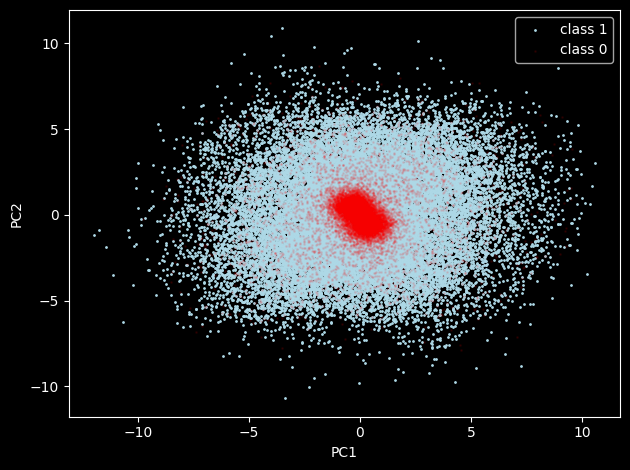

Chosen radius r0=14.679348 using dims=2 with f1=0.168409


Classifying globally-fitted: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]


Precicion: 0.0000
Recall: 0.0000
F1: 0.0000
Balanced accuracy: 0.5000


In [9]:
start = time()
scores = classifyTrace_unsupervised(
    trace_file=chameleon_file,
    vectorizer=vectorizer,
    classifier=classifier,
    stride=stride,
    window_size=window_size,
    epochs=2,
    tmp_folder = "temporary_files",
    batch_size=batch_size, # Bigger batch size hit's the memory limit of th docker
    stored_features_path = 'autoencoder_features/DFS' # Remove or none to extract new features, path in temporary_files otherwise
)
end = time()
with open("time.txt", "w") as f:
    f.write(str((end-start)//60))

'''
Recon error
Base: 0.021
'''

'''
2 comp:
0 size 6006936 p(class0) 0.00022407430343855835 p(class1) 0.9997759256965615
1 size 5814056 p(class0) 8.87504351523274e-05 p(class1) 0.9999112495648477
2 size 6455150 p(class0) 2.6025731392763918e-05 p(class1) 0.9999739742686072
3 size 12078656 p(class0) 0.33602587903819764 p(class1) 0.6639741209618024
4 size 6380900 p(class0) 7.209014402357034e-06 p(class1) 0.9999927909855977
5 size 6210734 p(class0) 0.00012381789334400733 p(class1) 0.999876182106656
Precicion: 0.9959936509625992
Recall: 0.9304698827782123
F1: 0.9621174447076606
Balanced accuracy: 0.9472808027939308
Cluster-to-class mapping: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1}

3dim radial:
Precicion: 0.9966852363689124
Recall: 0.8812903934975598
F1: 0.9354425046974395
Balanced accuracy: 0.9265917460740738

Ground truth threshholds:
0.6:
Precicion: 0.9901
Recall: 0.9110
F1: 0.9489
Balanced accuracy: 0.9174

0.5:
Precicion: 0.9972
Recall: 0.9223
F1: 0.9583
Balanced accuracy: 0.9486

0.45
Precicion: 0.9980
Recall: 0.9226
F1: 0.9588
Balanced accuracy: 0.9522

0.4:
Precicion: 0.9982
Recall: 0.9214
F1: 0.9582
Balanced accuracy: 0.9524

0.35
Precicion: 0.9983
Recall: 0.9200
F1: 0.9576
Balanced accuracy: 0.9520
'''

saveClassification(scores, output_file)

## Screening

Compute the segmenation and find the starting sample of each cryptographic operation.

In [5]:
import itertools

n_trace = 0
trace_len = 134_217_550
classification_file = output_file

labels = loaderGt(chameleon_file)

# Use memmap to avoid loading the whole file into RAM
classification = np.load(classification_file, mmap_mode="r")[n_trace]  # (num_windows, num_classes)

# --- GT starts/ends (FIX: append, don't overwrite) ---
label = next(itertools.islice(labels, n_trace, None))
gts_starts = label["start"]
gts_ends   = label["end"]

ground_truth_labels = np.zeros(trace_len, dtype=np.uint8)
for s, e in zip(gts_starts, gts_ends):
    if s < 0 or e < 0 or s >= trace_len:
        continue
    e = min(e, trace_len - 1)
    ground_truth_labels[s:e + 1] = 1

found_labels_ones = np.zeros(trace_len, dtype=np.uint16)
found_labels_count = np.zeros(trace_len, dtype=np.uint16)
for w, window_scores in enumerate(classification):
    start = w * stride
    end = start + window_size
    if start >= trace_len:
        break
    end = min(end, trace_len)

    if np.argmax(window_scores) == 1:
        found_labels_ones[start:end] += 1
    found_labels_count[start:end] += 1

co_classification_ratio = 0.47
found_labels = np.zeros(trace_len, dtype=np.uint8)

covered = found_labels_count > 0
found_labels[covered] = (found_labels_ones[covered] >= (co_classification_ratio * found_labels_count[covered])).astype(np.uint8)


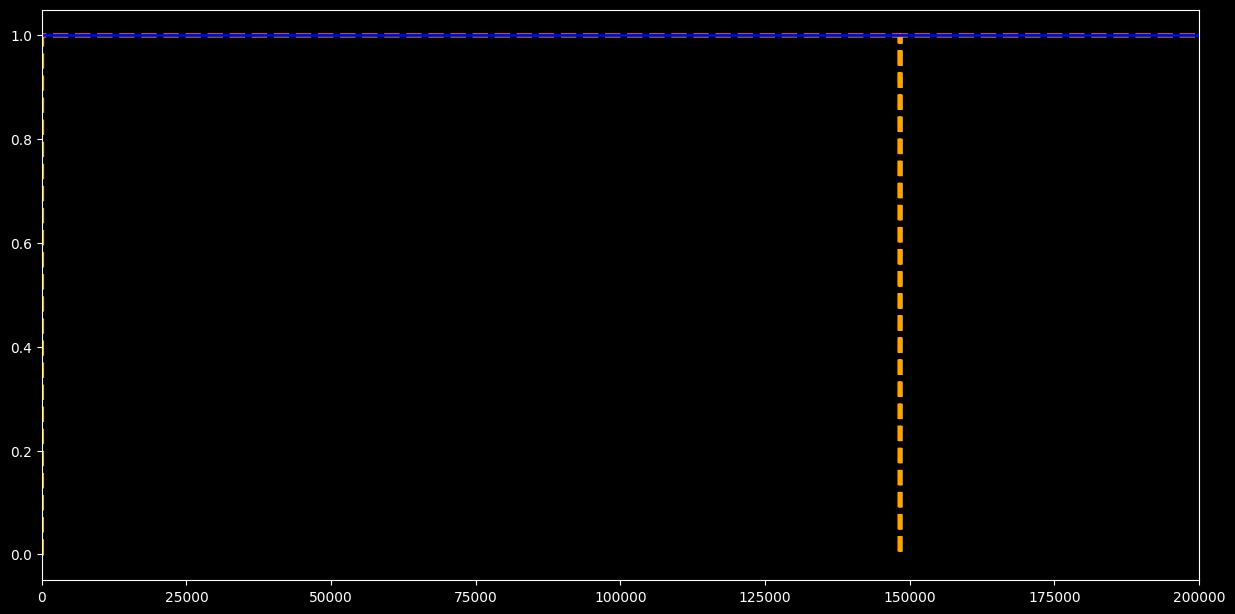

In [7]:
center = 100_000
margin = center
lim = (center - margin, center + margin)

fig, ax = plt.subplots(1, figsize=(13, 7))
plt.rcParams.update({'font.size': 18})
fig.tight_layout(pad=2.0)

ax.set_xlim(lim)

# GT dashed
ax.plot(ground_truth_labels, color="orange", linestyle="--", linewidth=3)

# Found labels
ax.plot(found_labels, color="blue", linewidth=2, alpha = 1)

# Dashed vertical lines for GT starts / ends inside limits
for s, e in zip(gts_starts, gts_ends):
    continue
    if lim[0] <= s <= lim[1]:
        ax.axvline(s, color="red", linestyle="--", alpha=0.4)
    if lim[0] <= e <= lim[1]:
        ax.axvline(e, color="white", linestyle="--", alpha=0.4)

plt.show()

In [6]:
# Per-label IoU + TPR/FPR/TNR/FNR (sample-level)

gt = ground_truth_labels.astype(bool)   # True = class 1
fd = found_labels.astype(bool)

intersection = np.count_nonzero(gt & fd)
union = np.count_nonzero(gt | fd)

iou = intersection / union if union > 0 else 0.0

TP = np.count_nonzero(gt & fd)
FP = np.count_nonzero(~gt & fd)
TN = np.count_nonzero(~gt & ~fd)
FN = np.count_nonzero(gt & ~fd)

# Class 1 (positive) rates
TPR_1 = TP / (TP + FN) if (TP + FN) else 0.0  # recall / sensitivity
FNR_1 = FN / (TP + FN) if (TP + FN) else 0.0
FPR_1 = FP / (FP + TN) if (FP + TN) else 0.0
TNR_1 = TN / (FP + TN) if (FP + TN) else 0.0  # specificity

# Class 1 IoU
IoU_1 = TP / (TP + FP + FN) if (TP + FP + FN) else 0.0

# Class 0 (treat class 0 as the “positive” class by swapping)
TP0, FP0, TN0, FN0 = TN, FN, TP, FP

TPR_0 = TP0 / (TP0 + FN0) if (TP0 + FN0) else 0.0
FNR_0 = FN0 / (TP0 + FN0) if (TP0 + FN0) else 0.0
FPR_0 = FP0 / (FP0 + TN0) if (FP0 + TN0) else 0.0
TNR_0 = TN0 / (FP0 + TN0) if (FP0 + TN0) else 0.0

IoU_0 = TP0 / (TP0 + FP0 + FN0) if (TP0 + FP0 + FN0) else 0.0

print(f"IoU: {iou:.4f}\n")

print("Class 1 (CO):")
print(f"  IoU={IoU_1:.4f}\n  TPR={TPR_1:.4f}  FPR={FPR_1:.4f}  TNR={TNR_1:.4f}  FNR={FNR_1:.4f}\n")

print("Class 0 (non-CO):")
print(f"  IoU={IoU_0:.4f}\n  TPR={TPR_0:.4f}  FPR={FPR_0:.4f}  TNR={TNR_0:.4f}  FNR={FNR_0:.4f}")


IoU: 0.9053

Class 1 (CO):
  IoU=0.9053
  TPR=1.0000  FPR=1.0000  TNR=0.0000  FNR=0.0000

Class 0 (non-CO):
  IoU=0.0000
  TPR=0.0000  FPR=0.0000  TNR=1.0000  FNR=1.0000
